# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random

# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

         0         1          2         3         4         5         6   \
0      15.1   5.10061  14.150364  0.641996  0.560755 -0.204328 -0.058190   
1      15.1   5.20122  13.846032  0.643660  0.560057 -0.206831 -0.056986   
2      15.1   5.30183  13.542532  0.645277  0.559330 -0.209271 -0.055732   
3      15.1   5.40244  13.239690  0.646846  0.558572 -0.211646 -0.054425   
4      15.1   5.50305  12.937316  0.648367  0.557781 -0.213957 -0.053062   
...     ...       ...        ...       ...       ...       ...       ...   
24742  86.1  25.28098  68.539411  0.889489  0.557742 -0.559551 -0.052669   
24743  86.1  25.81469  67.593048  0.892798  0.556636 -0.564524 -0.050794   
24744  86.1  26.34840  66.662881  0.896025  0.555496 -0.569388 -0.048861   
24745  86.1  26.88211  65.747951  0.899170  0.554318 -0.574146 -0.046868   
24746  86.1  27.41582  64.847338  0.902236  0.553103 -0.578799 -0.044812   

             7         8         9   ...        15        16        17  \
0      0.0735

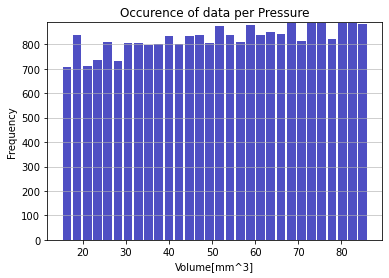

In [36]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Data_Spline/Spline.csv", header= None)

print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        #y0 is surface tension y1 is pressure
        y0 = data_matrix.iloc[0:,0].values
        y1 = data_matrix.iloc[0:,1].values
        
        # Add normalization for x
        # x = preprocessing.normalize(x)
        # y = preprocessing.normalize(y, axis = 0,norm='l2')
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Volume[mm^3]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Pressure')
        
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


### Load data for PictureNet
Read image from files

In [11]:
train_img = []

# data_image = pd.read_csv("Data_folder/Picture.csv", header= None)       # Small dataset
data_image = pd.read_csv("Data_folder/Data_Spline/Spline.csv", header= None) # Large dataset
for img_name in data_image.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_folder/Big_Data1/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 4236
Picture size = (82, 77)


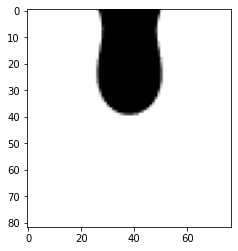

In [12]:
rand = random.randint(0, 24000)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

In [14]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:,3:].values            # modify the number depends on size of dataset
train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.2)    # default shuffle = True
val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)
len(train_x_pic)
# converting the trian images and targets into torch format
train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
train_x_pic  = torch.from_numpy(train_x_pic)
train_y_pic = torch.from_numpy(train_y_pic)
# print(train_x_pic.shape, train_y_pic.shape)

# converting the val images and targets into torch format
val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
val_x_pic  = torch.from_numpy(val_x_pic)
val_y_pic = torch.from_numpy(val_y_pic)
# print(val_x_pic.shape, val_y_pic.shape)

# converting the test images and targets into torch format
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = torch.from_numpy(test_y_pic)
# print(test_x_pic.shape, test_y_pic.shape)

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=64):
    batch = []
    batch_num = len(dataset) // batch_size
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

train_x_pic = batch_transform(train_x_pic)
train_y_pic = batch_transform(train_y_pic)
val_x_pic = batch_transform(val_x_pic)
val_y_pic = batch_transform(val_y_pic)
test_x_pic = batch_transform(test_x_pic)
test_y_pic = batch_transform(test_y_pic)
print(len(train_x_pic), len(train_y_pic), len(val_x_pic), len(val_y_pic), len(test_x_pic), len(test_y_pic))

309 309 38 38 38 38


### Deside to apply host or device


In [15]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


## Define the functions

In [16]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs",fontsize = 15)
    plt.ylabel("MSE Loss",fontsize = 15)
    plt.title("Train/Validation Loss",fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs",fontsize = 15)
    plt.ylabel("MSE Loss",fontsize = 15)
    plt.title("Train/Validation Loss",fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()


## Train PhysicsNet

In [17]:
in_channel = 22
node_1 = 1024
node_2 = 1024
node_3 = 512
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train_physics(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)


KeyboardInterrupt: 

### Visualization of outcomes

In [10]:
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
model_physics_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_physics_trained, x_test_example)
# y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:15])
print("Prediction    =", score_example[:15].reshape(15, 2))

Ground Truths = tensor([[64.8000, 20.7474],
        [32.3000, 10.9604],
        [80.9000, 30.6015],
        [37.7000, 10.2463],
        [36.9000, 15.5115],
        [62.7000, 29.2401],
        [55.6000, 18.2111],
        [64.5000, 20.6761],
        [28.0000, 12.3513],
        [55.6000, 15.7775],
        [47.8000, 20.3041],
        [40.6000, 17.5518],
        [36.9000, 13.4092],
        [42.3000, 12.4628],
        [85.7000, 40.0638]])
Prediction    = tensor([[65.0948, 20.3617],
        [32.8769, 10.4812],
        [76.0823, 28.6970],
        [39.1183, 11.0419],
        [36.6282, 15.0964],
        [60.9378, 27.5861],
        [58.4411, 18.2060],
        [64.8404, 20.2906],
        [27.1002, 11.7149],
        [57.1916, 15.7559],
        [49.6063, 20.9986],
        [42.3742, 17.9633],
        [36.7268, 12.8106],
        [43.9900, 12.7167],
        [78.3027, 35.2994]])


## Train PictureNet

epoch 1: train_loss = 0.0085, val_loss = 0.0088
epoch 2: train_loss = 0.0079, val_loss = 0.0083
epoch 3: train_loss = 0.0084, val_loss = 0.0085
epoch 4: train_loss = 0.0080, val_loss = 0.0083
epoch 5: train_loss = 0.0095, val_loss = 0.0101
epoch 6: train_loss = 0.0078, val_loss = 0.0083
epoch 7: train_loss = 0.0084, val_loss = 0.0086
epoch 8: train_loss = 0.0211, val_loss = 0.0226
epoch 9: train_loss = 0.0156, val_loss = 0.0167
epoch 10: train_loss = 0.0106, val_loss = 0.0113


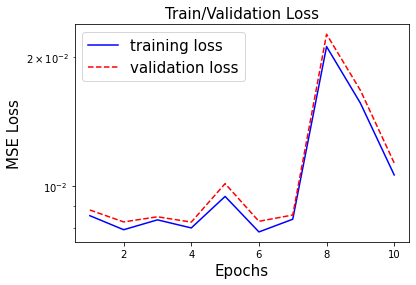

In [19]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-4

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 10

train_picture(model_picture, optimizer, epoch)
PATH_PIC = os.path.join(os.getcwd(), "model_pic")
torch.save(model_picture, PATH_PIC)

### Visualization of outcomes

In [20]:
# testing cell for better viewing the length
train_x_pic, train_y_pic

print(len(train_x_pic))
print(train_x_pic[0].shape)
print(train_y_pic[0].shape)

309
torch.Size([64, 1, 82, 77])
torch.Size([64, 22])


In [34]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic")
model_picture_trained = torch.load(PATH_PIC)
#Load YC matrix for point values
data_YC = pd.read_csv("Data_folder/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)

rand1 = random.randint(0, len(test_x_pic)-1)
rand2 = random.randint(0, 63)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic_pred = prediction(model_picture_trained, test_x_pic[rand1][rand2].reshape(1, 1, 82, 77))

#Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
score_pic_r = torch.matmul( YC,score_pic_pred[0, 0:11]) 
score_pic_z = torch.matmul( YC,score_pic_pred[0, 11:22])

test_y_pic_r = torch.matmul( YC,test_y_pic[rand1][rand2][0:11].float()) 
test_y_pic_z = torch.matmul( YC,test_y_pic[rand1][rand2][11:22].float()) 

for num in range(len(test_y_pic_r)):
   print(num+1, ": Ground Truths =", test_y_pic_z[num].item(), ", Prediction =", score_pic_z[num].item())


current batch = 35
current testing image = 7
1 : Ground Truths = -3.924579381942749 , Prediction = -3.773183584213257
2 : Ground Truths = -3.9238390922546387 , Prediction = -3.720794439315796
3 : Ground Truths = -3.9240152835845947 , Prediction = -3.7228195667266846
4 : Ground Truths = -3.922952651977539 , Prediction = -3.7341744899749756
5 : Ground Truths = -3.9192728996276855 , Prediction = -3.7365732192993164
6 : Ground Truths = -3.9116246700286865 , Prediction = -3.725536346435547
7 : Ground Truths = -3.898327112197876 , Prediction = -3.702315092086792
8 : Ground Truths = -3.8773081302642822 , Prediction = -3.6693215370178223
9 : Ground Truths = -3.8462111949920654 , Prediction = -3.6279585361480713
10 : Ground Truths = -3.802598476409912 , Prediction = -3.5779900550842285
11 : Ground Truths = -3.744189739227295 , Prediction = -3.5177905559539795
12 : Ground Truths = -3.6690921783447266 , Prediction = -3.4450089931488037
13 : Ground Truths = -3.575988292694092 , Prediction = -3.357

### Plot the ground truth and prediction to make a comparison

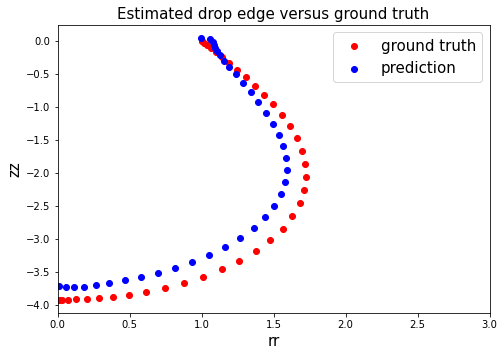

In [35]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(test_y_pic_r, test_y_pic_z, c="red", label="ground truth")
plt.scatter(score_pic_r, score_pic_z, c="blue", label="prediction")

plt.xlabel("rr",fontsize = 15)
plt.ylabel("zz",fontsize = 15)
plt.legend(fontsize = 15)


plt.show()